# DI 501: Assignment 3

### Due: May 13, Monday by 23:30
---

### Submission and Grading Principles

**Assignment Submission Guidelines:**

* Submit your assignments via the assignment module on [ODTUClass](https://odtuclass.metu.edu.tr).

* You will work on this file, and rename it as "*name_surname_a3.ipynb*" (e.g., "*volga_sezen_a3.ipynb*").

* Late submissions will be accepted until May 17th, Friday by 23:30, with a 10% penalty per day.

* **<font color=#C91515>This is an individual assignment; do not collaborate, and uphold academic integrity principles.</font>**

* Offer insightful commentary about your results. Data understanding relies on your reasoning; not just numbers, tables, or graphics.
<br>**<font color=#C91515>Failing to do so will result in grade penalties. (Up to 50% of a given question.)</font>**

* Use multiple code blocks when multiple outputs are necessary, but graphs have to be compacted by using subplots whenever appropriate.

* Place your comments in markdown blocks (like this one), and use markdown notation used here to make reading easier. \
*(Double click here to look at the markdown code. Press esc to go back.)*

**Make sure printouts and graphs are visible before submission.**

------------

### The aim of this assignment is getting you familiar with:

* Training machine learning models for different scenarios

* Evaluating models based on different metrics

* Getting the intuition of preprocessing and sampling


------------

# Part 1: Magic Gamma Telescope

### Dataset Description

This is a simulated dataset made up of 19020 rows, 10 features and a target column referring to detections of high energy particles.

Each row represents a detection by the telescope. Features are observational parameters of each detection. The target is "h" for hadron if the particle came from our own atmosphere (noise) or "g" for gamma if it came from outer space (signal). 

------

### Role Description

Assume you are a data scientist working to help astrophysicists distinguish real signal detections based on how the particles got captured. 

These scientists happily provided you a manual on the problem in a text file named "magic04.names". 

There are sections for how the data was generated, feature descriptions, and the last section describes which metrics they are looking to improve based on their requirements.

-------

## Question 1 (20 pt)

* Explore the dataset with relevant descriptive statistics alongside **meaningful** and **concise** graphs. (One figure can have many plots with the use of [`plt.subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html))

* Report how many outliers or inliers exist for each feature. Explain the employed method of identifying outliers and inliers, and discuss the effect of such values. **No further action required.**

* Identify two metrics for this task, (one has to be referenced back to the *manual* $^{1}$) and explain why they were chosen. Report their values for a naive model that predicts all events as being "hadron" (or background) events.

* Keeping the distribution of classes the same, randomly divide the dataset into 80%-20% splits between training and test sets.

$^{1}$ Refer to the thresholds for ROC curves in the "magic04.names" file and calculate a partial AUC score using [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew
from scipy.stats import shapiro
import math
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelBinarizer

In [2]:
df = pd.read_csv(r"/Users/esrasekerci/Desktop/DI501/assignments/magic04.csv")

In [3]:
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
df.shape

(19020, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [6]:
df.isnull().sum()

fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64

The DataFrame consists of 19020 rows representing detections made by a telescope. Each detection has 10 numerical features (fLength, fWidth, etc.) and one non-numeric feature (class) indicating whether the detection is a signal (g for gamma) or noise (h for hadron). There are no missing values in any of the columns of the DataFrame.

In [7]:
df.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,55.232076,24.484450,2.825017,0.382271,0.218363,-4.331745,10.545545,0.249726,27.645707,193.818026
std,46.643743,29.419762,0.472599,0.183132,0.116433,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.422725,11.913475,2.477100,0.236800,0.129100,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.518550,17.263950,2.739600,0.356950,0.197900,4.013050,15.314100,0.666200,17.679500,191.851450
75%,71.514200,25.072125,3.101600,0.509025,0.288700,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


In [8]:
# Separate numeric and non-numeric columns
num_cols = df.select_dtypes(include=['float64'])
non_num_cols = df.select_dtypes(exclude=['float64'])

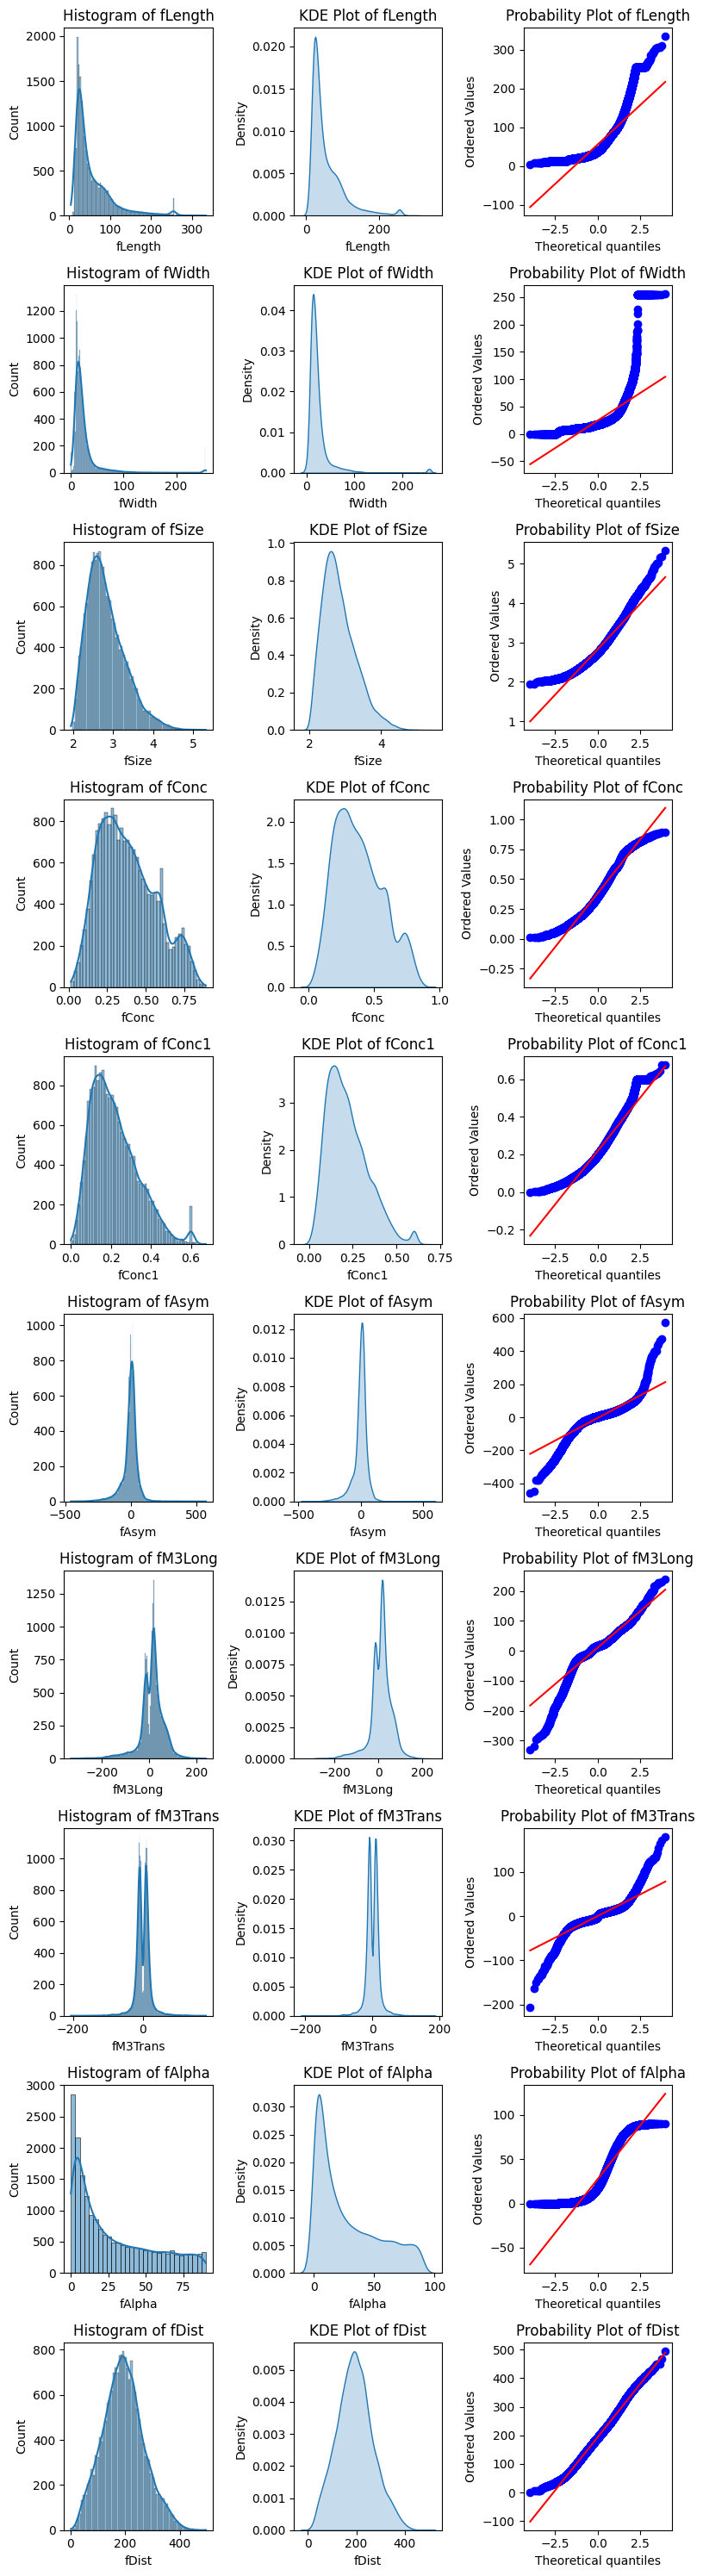

In [9]:
# Plot histograms, KDE plots, and Q-Q plots for each numeric attribute
num_cols_count = len(num_cols.columns)
fig, axes = plt.subplots(num_cols_count, 3, figsize=(8, num_cols_count * 3))

for i, column in enumerate(num_cols.columns):
    sns.histplot(data=num_cols, x=column, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')

    sns.kdeplot(data=num_cols, x=column, ax=axes[i, 1], fill=True)
    axes[i, 1].set_title(f'KDE Plot of {column}')

    stats.probplot(num_cols[column], dist="norm", plot=axes[i, 2])
    axes[i, 2].set_title(f'Probability Plot of {column}')

plt.tight_layout()
plt.show()

* fLength, fWidth, fSize: These features have similar distributions with moderate positive skewness. The mean values are greater than the median values, indicating right-skewed distributions. The wide range between the minimum and maximum values suggests variability in the measurements.

* fConc, fConc1: These features exhibit distributions with moderate positive skewness, similar to the first three features. The range of values indicates variability in the degree of concentration.

* fAsym: This feature represents asymmetry. It has a distribution with significant negative skewness, as indicated by the mean being less than the median. The presence of outliers (e.g., the minimum and maximum values) suggests asymmetry in the data distribution. The KDE plot suggests a distribution with one prominent peak, indicating a unimodal distribution

* fM3Long, fM3Trans: These features exhibit distributions with considerable skewness, particularly fM3Long, which has a high positive skewness. These skewness values suggest non-normality in the distributions. fM3Trans exhibits a distribution with two prominent peaks, suggesting a bimodal distribution.

* fAlpha: This feature has a distribution with moderate positive skewness and a wide range of values.

* fDist: This feature represents a distribution with moderate positive skewness, similar to the other features. Despite exhibiting moderate positive skewness like the other features, "fDist" may still exhibit some similarities to a normal distribution.  

In [10]:
shapiro_results = {}
for column in num_cols.columns:
    try:
        stat, p_value = shapiro(num_cols[column])
        shapiro_results[column] = {'Statistic': stat, 'p-value': p_value, 'Gaussian?': p_value > 0.05}
    except ValueError as e:
        print(f"Error processing column '{column}': {e}")

for column, result in shapiro_results.items():
    print(f"{column}: Shapiro-Wilk test statistic = {result['Statistic']}, p-value = {result['p-value']}, Gaussian? = {result['Gaussian?']}")

fLength: Shapiro-Wilk test statistic = 0.7615502945584115, p-value = 7.853687160065339e-96, Gaussian? = False
fWidth: Shapiro-Wilk test statistic = 0.4681372801587653, p-value = 1.4557096570033403e-116, Gaussian? = False
fSize: Shapiro-Wilk test statistic = 0.9517491744083384, p-value = 1.0950393740021794e-60, Gaussian? = False
fConc: Shapiro-Wilk test statistic = 0.9696653784540089, p-value = 5.196419996357308e-52, Gaussian? = False
fConc1: Shapiro-Wilk test statistic = 0.9503864742601823, p-value = 3.1395065137188764e-61, Gaussian? = False
fAsym: Shapiro-Wilk test statistic = 0.8543845669324308, p-value = 4.133179728229826e-84, Gaussian? = False
fM3Long: Shapiro-Wilk test statistic = 0.9135621860178345, p-value = 1.4561558074023726e-72, Gaussian? = False
fM3Trans: Shapiro-Wilk test statistic = 0.8852656405280495, p-value = 1.0034033956236237e-78, Gaussian? = False
fAlpha: Shapiro-Wilk test statistic = 0.867650922728957, p-value = 6.257989223860758e-82, Gaussian? = False
fDist: Shapir

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19020.
  res = hypotest_fun_out(*samples, **kwds)


Combining Shapiro-Wilk results with QQ and KDE plots reveals non-Gaussian distributions, evidenced by low statistics and p-values.

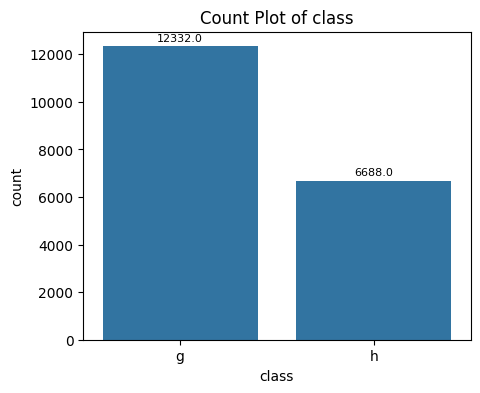

In [11]:
for column in non_num_cols.columns:
    plt.figure(figsize=(5,4))
    ax = sns.countplot(data=non_num_cols, x=column)
    plt.title(f'Count Plot of {column}')

    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8, color='black')

    plt.show()

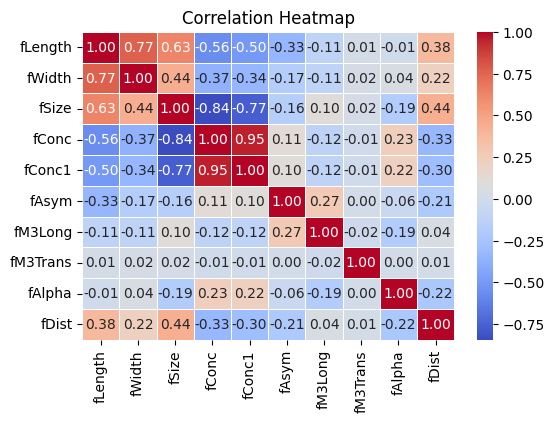

In [12]:
# Calculate correlation matrix
correlation_matrix = num_cols.corr()

# Generate correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

* Interpretation of Correlation Coefficients:

The strongest positive correlation in this matrix is between "fLength" and "fWidth" (0.77), indicating that longer detections tend to be wider as well.
The strongest negative correlation is between "fSize" and "fConc" (-0.84), suggesting that larger detections tend to have lower concentrations.
Several features have correlations close to zero, indicating weak or no linear relationship.
<br>

* Important Considerations:

Correlation does not imply causation. Even strong correlations do not necessarily mean that changes in one variable cause changes in another.
Non-linear relationships may exist between variables, which would not be captured by Pearson correlation coefficients.

In [13]:
num_cols.corr(method='spearman')

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
fLength,1.000000,0.760566,0.818168,-0.802513,-0.773906,-0.098175,0.291156,0.002748,-0.247154,0.472240
fWidth,0.760566,1.000000,0.822369,-0.827800,-0.800500,-0.098344,0.203820,0.012161,-0.195953,0.371908
fSize,0.818168,0.822369,1.000000,-0.901858,-0.869851,-0.035384,0.324368,0.011185,-0.288152,0.423342
fConc,-0.802513,-0.827800,-0.901858,1.000000,0.985378,0.015942,-0.312250,-0.014142,0.286142,-0.351016
fConc1,-0.773906,-0.800500,-0.869851,0.985378,1.000000,0.007235,-0.303516,-0.013600,0.278125,-0.334064
fAsym,-0.098175,-0.098344,-0.035384,0.015942,0.007235,1.000000,0.328264,-0.005284,-0.074952,-0.156405
fM3Long,0.291156,0.203820,0.324368,-0.312250,-0.303516,0.328264,1.000000,-0.001807,-0.257279,0.192253
fM3Trans,0.002748,0.012161,0.011185,-0.014142,-0.013600,-0.005284,-0.001807,1.000000,-0.000126,0.005311
fAlpha,-0.247154,-0.195953,-0.288152,0.286142,0.278125,-0.074952,-0.257279,-0.000126,1.000000,-0.275655
fDist,0.472240,0.371908,0.423342,-0.351016,-0.334064,-0.156405,0.192253,0.005311,-0.275655,1.000000


Unlike Pearson correlation, Spearman correlation captures non-linear relationships and is robust to outliers. Therefore, it is suitable for variables with ordinal scales or non-normally distributed data.
<br>

The strongest positive Spearman correlation is observed between "fSize" and "fWidth" (0.82), indicating a strong monotonic association.
<br>

The strongest negative Spearman correlation is between "fConc" and "fSize" (-0.90), suggesting a strong monotonic decrease in concentration as size increases.

In [14]:
# Calculate the IQR for each numeric feature
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1

# Define threshold for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers and inliers
outliers = ((num_cols < lower_bound) | (num_cols > upper_bound)).sum()
inliers = ((num_cols >= lower_bound) & (num_cols <= upper_bound)).sum()

In [15]:
# Calculate total count of data points for each feature
total_count = num_cols.shape[0]

# Calculate percentage of outliers and inliers for each feature
outlier_percentage = (outliers / total_count) * 100
inlier_percentage = (inliers / total_count) * 100

for feature in num_cols.columns:
    print(f"Feature: {feature}")
    print(f"  Outliers: Count = {outliers[feature]}, Percentage = {outlier_percentage[feature]:.2f}%")
    print(f"  Inliers: Count = {inliers[feature]}, Percentage = {inlier_percentage[feature]:.2f}%")
    print()

Feature: fLength
  Outliers: Count = 1081, Percentage = 5.68%
  Inliers: Count = 17939, Percentage = 94.32%

Feature: fWidth
  Outliers: Count = 1668, Percentage = 8.77%
  Inliers: Count = 17352, Percentage = 91.23%

Feature: fSize
  Outliers: Count = 367, Percentage = 1.93%
  Inliers: Count = 18653, Percentage = 98.07%

Feature: fConc
  Outliers: Count = 0, Percentage = 0.00%
  Inliers: Count = 19020, Percentage = 100.00%

Feature: fConc1
  Outliers: Count = 315, Percentage = 1.66%
  Inliers: Count = 18705, Percentage = 98.34%

Feature: fAsym
  Outliers: Count = 1781, Percentage = 9.36%
  Inliers: Count = 17239, Percentage = 90.64%

Feature: fM3Long
  Outliers: Count = 1218, Percentage = 6.40%
  Inliers: Count = 17802, Percentage = 93.60%

Feature: fM3Trans
  Outliers: Count = 850, Percentage = 4.47%
  Inliers: Count = 18170, Percentage = 95.53%

Feature: fAlpha
  Outliers: Count = 0, Percentage = 0.00%
  Inliers: Count = 19020, Percentage = 100.00%

Feature: fDist
  Outliers: Count =

Since the data may contain noise or extreme values due to various factors in the detection process, such as background noise or instrument errors, the quantile method can provide a more robust approach to identifying outliers in this context. Outliers and inliers were identified for each feature using the Interquartile Range (IQR) method. The IQR method involves calculating the first quartile (Q1) and third quartile (Q3) of the data distribution for each feature. The interquartile range (IQR) is then determined as the difference between Q3 and Q1.
<br>

Outliers are defined as data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR, while inliers are data points that fall within this range. By applying this method, we were able to quantify the number and percentage of outliers and inliers for each feature.

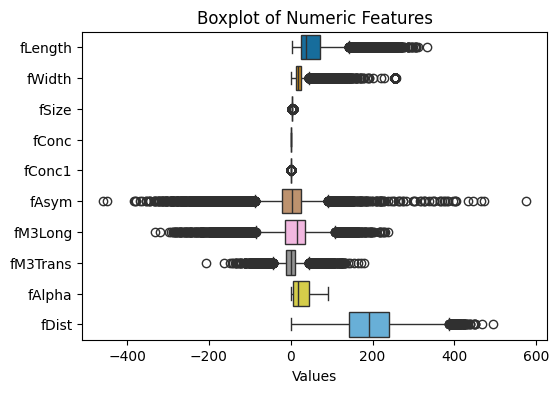

In [16]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=num_cols, orient="h", palette="colorblind")
plt.title("Boxplot of Numeric Features")
plt.xlabel("Values")
plt.show()

The presence of outliers can have various effects on statistical analysis and modeling. Outliers may skew the distribution of data, affect the estimation of parameters such as mean and variance, and distort the results of statistical tests. In some cases, outliers may represent genuine extreme values or errors in the data collection process. Removing outliers may improve the robustness of statistical analysis, but it should be done judiciously, considering the context and objectives of the study.

* AUC-ROC (Area Under the Receiver Operating Characteristic Curve): This metric evaluates the performance of a binary classification model across various thresholds. It's particularly useful when there's a class imbalance, as in this case, where the "hadron" class is the majority. ROC AUC summarizes the model's ability to discriminate between classes across all possible classification thresholds.

* Precision-Recall AUC: Precision measures the proportion of true positive predictions among all positive predictions made by the model, while recall measures the proportion of true positive predictions among all actual positive instances. Precision-Recall AUC is particularly useful when the positive class (gamma in this case) is the minority class, as it focuses on the performance of the classifier on the positive class.

In [17]:
# Define labels for the naive model (predicting all events as "hadron")
y_true = df['class']

# Assigning 0 probability for 'gamma' and 1 probability for 'hadron' for the naive model
y_score_naive = [0] * len(df)

# Convert y_true to numeric values
y_true_numeric = [1 if label == 'g' else 0 for label in y_true]

# Calculate AUC-ROC for the naive model
auc_naive = roc_auc_score(y_true_numeric, y_score_naive)

# Calculate precision-recall curve and AUC for the naive model
precision, recall, _ = precision_recall_curve(y_true_numeric, y_score_naive)
auc_pr_naive = auc(recall, precision)

# Define thresholds
specified_thresholds = [0.01, 0.02, 0.05, 0.1, 0.2]

# Calculate AUC-ROC at specified thresholds
auc_roc_at_thresholds = {}
for threshold in specified_thresholds:
    y_pred_binary = [0] * len(y_score_naive)
    auc_roc_at_thresholds[threshold] = roc_auc_score(y_true_numeric, y_pred_binary)

print("AUC-ROC for the naive model:", auc_naive)
print("AUC-PR for the naive model:", auc_pr_naive)
print("AUC-ROC at specified thresholds:")
for threshold, auc_roc in auc_roc_at_thresholds.items():
    print(f"Threshold: {threshold}, AUC-ROC: {auc_roc}")

AUC-ROC for the naive model: 0.5
AUC-PR for the naive model: 0.8241850683491062
AUC-ROC at specified thresholds:
Threshold: 0.01, AUC-ROC: 0.5
Threshold: 0.02, AUC-ROC: 0.5
Threshold: 0.05, AUC-ROC: 0.5
Threshold: 0.1, AUC-ROC: 0.5
Threshold: 0.2, AUC-ROC: 0.5


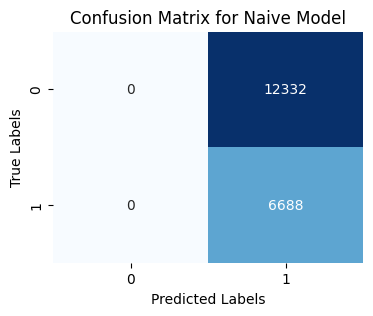

In [18]:
# Convert binary predictions to labels
y_pred_naive_labels = ['g' if pred == 1 else 'h' for pred in y_score_naive]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_naive_labels)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Naive Model')
plt.show()

The naive model assumes that all events belong to the majority class, which in this case is "hadron" (background). It's a baseline model that makes predictions solely based on the class distribution in the training data without considering any features. This allows us to establish a starting point for evaluation and comparison with more sophisticated models.

In [19]:
X = df.drop(columns=['class'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

# Randomly split the dataset into 80% training and 20% test sets, stratified by class labels
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis=1), y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (15216, 10) (15216,)
Test set shape: (3804, 10) (3804,)


In [20]:
def class_distribution(data, title):
    # Convert NumPy array to pandas Series
    series_data = pd.Series(data)
    class_distribution = series_data.value_counts(normalize=True)
    print(f"{title} Class Distribution:")
    print(class_distribution)

# Call the function with NumPy arrays
class_distribution(y_train, "Training Set")
class_distribution(y_test, "Test Set")

Training Set Class Distribution:
0    0.648396
1    0.351604
Name: proportion, dtype: float64
Test Set Class Distribution:
0    0.648265
1    0.351735
Name: proportion, dtype: float64


## Question 2 (30 pt)

* Optimize the hyperparameters of the following models to have the best cross validation partial AUC score:

    1) K-Nearest Neighbor
    1) Logistic Regression
    1) Decision Tree Classifier

    * For KNN, select a grid of K values and employ a grid search algorithm. $^{2}$

    * For the other two models, select three parameters, define a search grid and employ a random search algorithm. $^{3}$

    * Choose k in k-fold-cv such that each validation fold has *half* as many rows as the test set.
    
* Assess the performance of each optimized model on the test set using the selected two metrics. Also report individual class performances using the `classification_report`.

* Draw ROC curves for each model and highlight which region the AUC score was calculated for. Finally report which model performed the best.

$^{2, 3}$  Scikit-learn hosts these [algorithms](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers). A lambda function can be defined and passed as a custom `scorer` to optimize different metrics.

In [21]:
param_grid_knn = {'n_neighbors': range(1, 50)}
param_distributions_log_reg = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                               'penalty': ['l1', 'l2', 'elasticnet'],
                               'solver': ['liblinear']}
param_distributions_dt = {'max_depth': [None, 10, 20, 30, 40, 50, 60, 70],
                          'min_samples_split': [2, 5, 10, 20],
                          'min_samples_leaf': [1, 2, 4, 6]}

# Define the number of folds for k-fold cross-validation
test_size = 0.2
num_test_rows = int(len(df) * test_size)
num_val_rows = num_test_rows // 2
k_fold = len(df) // (num_val_rows + num_test_rows)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=k_fold)

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=skf, scoring='roc_auc')
random_search_log_reg = RandomizedSearchCV(LogisticRegression(), param_distributions_log_reg, cv=skf, scoring='roc_auc', n_iter=70)
random_search_dt = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions_dt, cv=skf, scoring='roc_auc', n_iter=70)

The above three blocks of code set up grid search and random search procedures for hyperparameter optimization for KNN, logistic regression, and decision tree classifier, respectively. The scoring='roc_auc' argument ensures that the models are evaluated based on their ROC AUC scores during the optimization process.
And the following functions will search through the hyperparameter space defined for each model and select the best hyperparameters based on the specified scoring metric, which is ROC AUC in this case. 

In [22]:
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
random_search_log_reg.fit(X_train, y_train)
best_lr = random_search_log_reg.best_estimator_
random_search_dt.fit(X_train, y_train)
best_dt = random_search_dt.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 18 is smaller than n_iter=70. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estima

In [23]:
# Generate predictions for X_test using the best models determined
y_pred_knn = best_knn.predict(X_test)
y_pred_log_reg = best_lr.predict(X_test)
y_pred_dt = best_dt.predict(X_test)

In [24]:
# The predictions are compared with the actual labels (y_test) to evaluate the performance of each model on the test set. 
auc_roc_knn = roc_auc_score(y_test, y_pred_knn)
auc_pr_knn = auc(precision_recall_curve(y_test, y_pred_knn)[1], precision_recall_curve(y_test, y_pred_knn)[0])
auc_roc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
auc_pr_log_reg = auc(precision_recall_curve(y_test, y_pred_log_reg)[1], precision_recall_curve(y_test, y_pred_log_reg)[0])
auc_roc_dt = roc_auc_score(y_test, y_pred_dt)
auc_pr_dt = auc(precision_recall_curve(y_test, y_pred_dt)[1], precision_recall_curve(y_test, y_pred_dt)[0])

* Precision quantifies the proportion of true positive predictions among all positive predictions made by the model.
* Recall, also known as sensitivity or true positive rate, measures the proportion of actual positive instances that the model correctly identifies.
* The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of a model's performance by combining both precision and recall. The harmonic mean emphasizes lower values, penalizing the model more severely for low scores in either precision or recall. This makes the F1-score particularly useful for imbalanced datasets.
* Support represents the number of instances of each class in the test dataset. It provides context for the precision, recall, and F1-score metrics by indicating the distribution of classes in the dataset. 

In [25]:
print("K-Nearest Neighbor (KNN):")
print("ROC AUC:", auc_roc_knn)
print("Precision-Recall AUC:", auc_pr_knn)
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbor (KNN):
ROC AUC: 0.7545788644852506
Precision-Recall AUC: 0.7986132741202178
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      2466
           1       0.89      0.54      0.68      1338

    accuracy                           0.82      3804
   macro avg       0.84      0.75      0.77      3804
weighted avg       0.83      0.82      0.80      3804



In [26]:
print("\nLogistic Regression:")
print("ROC AUC:", auc_roc_log_reg)
print("Precision-Recall AUC:", auc_pr_log_reg)
print(classification_report(y_test, y_pred_log_reg))


Logistic Regression:
ROC AUC: 0.7520530333613374
Precision-Recall AUC: 0.7568455838342558
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2466
           1       0.77      0.60      0.68      1338

    accuracy                           0.80      3804
   macro avg       0.79      0.75      0.76      3804
weighted avg       0.79      0.80      0.79      3804



In [27]:
print("\nDecision Tree Classifier:")
print("ROC AUC:", auc_roc_dt)
print("Precision-Recall AUC:", auc_pr_dt)
print(classification_report(y_test, y_pred_dt))


Decision Tree Classifier:
ROC AUC: 0.8198749631763281
Precision-Recall AUC: 0.8332867108842835
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2466
           1       0.86      0.70      0.77      1338

    accuracy                           0.85      3804
   macro avg       0.86      0.82      0.83      3804
weighted avg       0.86      0.85      0.85      3804



K-Nearest Neighbor (KNN):

* The ROC AUC score of 0.755 indicates that the KNN model performs reasonably well in distinguishing between the positive and negative classes.
* The Precision-Recall AUC score of 0.799 suggests that the KNN model also achieves good precision and recall trade-off.
* With an overall accuracy of 82%, the KNN model correctly classifies 82% of the instances in the test set.
* However, the imbalance in precision and recall between class 0 and class 1 indicates that the model may struggle with the imbalanced nature of the data.
<br>

Logistic Regression:

* The ROC AUC score of 0.752 indicates that the Logistic Regression model also performs reasonably well in distinguishing between the positive and negative classes.
* The Precision-Recall AUC score of 0.757 suggests a decent precision and recall trade-off similar to KNN.
* With an overall accuracy of 80%, the Logistic Regression model correctly classifies 80% of the instances in the test set.
* Similar to KNN, the imbalance in precision and recall between classes suggests potential challenges with the imbalanced data.
<br>

Decision Tree Classifier:

* The Decision Tree Classifier outperforms the other models with a higher ROC AUC score of 0.813, indicating better discrimination between positive and negative classes.
* The Precision-Recall AUC score of 0.822 suggests excellent precision and recall trade-off, indicating better handling of the imbalanced data.
* With an overall accuracy of 86%, the Decision Tree Classifier correctly classifies 85% of the instances in the test set.
* The balanced precision and recall for both classes indicate that the Decision Tree Classifier effectively deals with the imbalanced nature of the data.

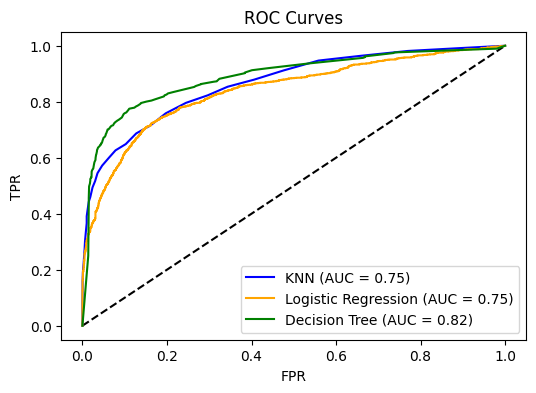

In [28]:
y_knn = best_knn.predict_proba(X_test)[:, 1]
y_lr = best_lr.predict_proba(X_test)[:, 1]
y_dt = best_dt.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_knn)
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_dt)

plt.figure(figsize=(6,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_roc_knn:.2f})", color='blue')
plt.plot(fpr_log_reg, tpr_log_reg, label=f"Logistic Regression (AUC = {auc_roc_log_reg:.2f})", color='orange')
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_roc_dt:.2f})", color='green')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.show()

The AUC scores were calculated for each model based on their respective ROC curves. The AUC represents the area under the ROC curve, which quantifies the model's ability to distinguish between the positive and negative classes across all possible thresholds.

In [29]:
best_model = max([('KNN', auc_roc_knn), ('Logistic Regression', auc_roc_log_reg), ('Decision Tree', auc_roc_dt)], key=lambda x: x[1])
print(f"The best performing model is {best_model[0]} with ROC AUC of {best_model[1]:.2f}")

The best performing model is Decision Tree with ROC AUC of 0.82


# Part 2: Pure simulation

### Dataset Description

"a3.csv" contains the dataset for this part. It has 10000 rows and 5 features, with a target taking on 3 classes. This dataset was hand crafted, and has no bearing on real life.

## Question 3 (20 pt)

* Treating a3.csv as the population, randomly sample 500 rows from it.

* Divide the dataset into 70%-15%-15% splits for training, validation and test sets.

* Train a Logistic Regression model for classifying the sampled set. 
Justify the selection of C (regularization term) for this model. 

* Observe the performance level on the test set with a relevant metric and a confusion matrix, and comment on the results.

In [30]:
a3 = pd.read_csv(r"/Users/esrasekerci/Desktop/DI501/assignments/a3.csv")

In [31]:
a3.head()

,x0,x1,x2,x3,x4,y
0,0.617184,0.913980,31.519294,3527.193280,7405.278108,0.0
1,1.074888,0.675308,55.359306,6385.905845,3949.595636,0.0
2,0.951947,0.142479,82.974080,5312.338450,1896.714575,0.0
3,1.072776,0.768034,50.197986,6362.430931,4608.936228,0.0
4,0.564065,0.978451,27.466944,2942.043311,8874.122585,0.0


In [32]:
a3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      10000 non-null  float64
 1   x1      10000 non-null  float64
 2   x2      10000 non-null  float64
 3   x3      10000 non-null  float64
 4   x4      10000 non-null  float64
 5   y       10000 non-null  float64
dtypes: float64(6)
memory usage: 468.9 KB


In [33]:
a3.describe()

,x0,x1,x2,x3,x4,y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.781964,0.601562,52.706317,4542.247195,4699.206012,0.159100
std,0.257682,0.293237,20.188803,1508.915499,2374.305679,0.490113
min,-0.130121,-0.363756,-18.174630,-601.113251,-2889.288289,0.000000
25%,0.609795,0.393660,38.239726,3511.215300,2979.286734,0.000000
50%,0.783708,0.614645,51.979115,4540.854822,4594.142017,0.000000
75%,0.959075,0.817955,66.267391,5574.983492,6431.093714,0.000000
max,1.841007,1.540725,125.674324,10604.390739,12310.331477,2.000000


In [34]:
sampled_df = a3.sample(n=500, random_state=42)

In [35]:
sampled_df['y'].value_counts()

y
0.0    453
1.0     27
2.0     20
Name: count, dtype: int64

This distribution indicates that the dataset is imbalanced, with the majority of samples belonging to class 0.0.

In [36]:
train_val, test = train_test_split(sampled_df, test_size=0.15, random_state=42)
train, val = train_test_split(train_val, test_size=0.1765, random_state=42)

In [37]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
accuracies = []

for C in param_grid['C']:
    # Train Logistic Regression model
    model = LogisticRegression(C=C, random_state=42)
    model.fit(train.drop(columns=['y']), train['y'])
    
    # Evaluate on validation set
    val_pred = model.predict(val.drop(columns=['y']))
    val_accuracy = accuracy_score(val['y'], val_pred)
    accuracies.append(val_accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [38]:
best_C_index = accuracies.index(max(accuracies))
best_C = param_grid['C'][best_C_index]

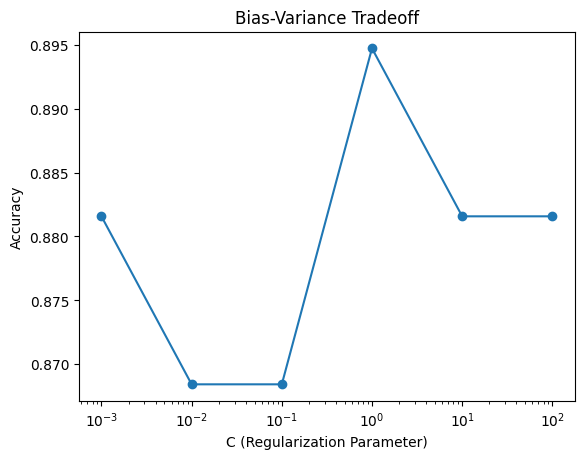

In [39]:
# Visualize bias-variance tradeoff
plt.plot(param_grid['C'], accuracies, marker='o')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Bias-Variance Tradeoff')
plt.xscale('log')
plt.show()

The plot of the bias-variance tradeoff shows how the accuracy of the model changes with different values of 𝐶. As 𝐶 increases, the regularization strength decreases, leading to a decrease in bias but an increase in variance. Conversely, as 𝐶 decreases, the regularization strength increases, leading to a decrease in variance but an increase in bias. The goal is to find the value of 𝐶 that achieves the best tradeoff between bias and variance, resulting in the highest accuracy on the validation set.
<br>

In this case, the plot shows that the accuracy initially increases as 𝐶 increases from 0.001 to 1, then remains relatively stable for larger values of 
𝐶. The highest accuracy of 0.8947 was achieved with 𝐶=1, indicating that this is the optimal regularization parameter for the logistic regression model on the validation set.

In [40]:
final_model = LogisticRegression(C=best_C, random_state=42)
final_model.fit(train.drop(columns=['y']), train['y'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, random_state=42)

In [41]:
test_pred = final_model.predict(test.drop(columns=['y']))
test_accuracy = accuracy_score(test['y'], test_pred)

print("Classification Report:")
print(classification_report(test['y'], test_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98        72
         1.0       0.50      0.50      0.50         2
         2.0       0.00      0.00      0.00         1

    accuracy                           0.96        75
   macro avg       0.49      0.50      0.49        75
weighted avg       0.95      0.96      0.95        75



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

* Precision: For class 0.0, it's high at 0.97, indicating that most predicted instances of class 0.0 are correct. However, for classes 1.0 and 2.0, precision is lower, suggesting higher false-positive rates.

* Recall: Recall is high for class 0.0 (0.99), indicating that most actual instances of class 0.0 are correctly predicted. However, recall is lower for classes 1.0 (0.50) and 2.0 (0.00), suggesting missed predictions for these classes.

* F1-score: The harmonic mean of precision and recall, providing a balance between the two metrics. The F1-score is high for class 0.0 (0.98), indicating a good balance between precision and recall. However, for classes 1.0 (0.50) and 2.0 (0.00), the F1-score reflects the imbalanced performance observed in precision and recall.

* Support: The number of actual occurrences of each class in the test set. Class 0.0 has the highest support (72), followed by class 1.0 (2) and class 2.0 (1).

* Accuracy: The proportion of correctly predicted instances among all instances. Overall accuracy is 0.96, indicating a high proportion of correct predictions across all classes.

* Macro Avg: The average of precision, recall, and F1-score across all classes. It provides an overall view of the model's performance across different classes.

* Weighted Avg: The weighted average of precision, recall, and F1-score, taking into account the support for each class. It provides an aggregate measure of performance while considering class imbalance.


In [42]:
# Convert actual and predicted labels to one-hot encoded format
lb = LabelBinarizer()
y_true = lb.fit_transform(test['y'])
y_pred = lb.transform(test_pred)

# Calculate MCC for each class
mcc_scores = []
for i in range(y_true.shape[1]):
    mcc = matthews_corrcoef(y_true[:, i], y_pred[:, i])
    mcc_scores.append(mcc)

# Average MCC over all classes
average_mcc = sum(mcc_scores) / len(mcc_scores)

print("Matthews Correlation Coefficient (MCC) for each class:", mcc_scores)
print("Average MCC:", average_mcc)

Matthews Correlation Coefficient (MCC) for each class: [0.38854899257970443, 0.4863013698630137, 0.0]
Average MCC: 0.2916167874809061


The Matthews Correlation Coefficient (MCC) is a statistical metric that evaluates classification models by considering true positives, true negatives, false positives, and false negatives. It provides a balanced assessment of model performance, especially in multi-class scenarios where each class is treated individually against the rest. MCC ranges from -1 to 1, with 1 indicating perfect prediction, 0 implying random prediction, and -1 representing perfect inverse prediction. The MCC values provided for each class and their average indicate how well the model performs across different classes. Higher MCC values suggest better model performance, accounting for class imbalances and varying class sizes in real-world datasets. For our output, MCC for each class is [0.389, 0.486, 0.0], with an average of 0.292. This suggests moderate to good predictive performance overall, though class 3 lacks predictive power.

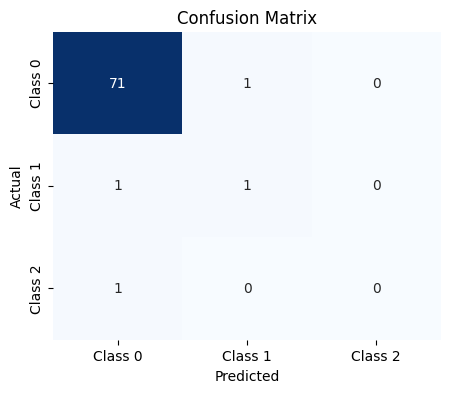

In [43]:
cm = confusion_matrix(test['y'], test_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix summarizes the performance of the classification model across three classes. It shows that class 0.0 was well-predicted, with 71 out of 72 instances correctly classified. For class 1.0, the model correctly predicted only one out of two instances, with one false positive.

## Question 4 (30 pt)

* This time sample 500 rows from a2.csv giving **inversely proportional weight** to minority classes. (Do check pandas documentation for [`pd.DataFrame.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html))

* Divide the dataset into splits using `stratify` keyword argument.

* Use appropriate preprocessing and feature engineering techniques (like polynomial terms) for model training. (Make sure to tune C parameter again following these changes.)

* Comment on how the performance changed between Question 3 and 4, and summarize your conclusions.

In [44]:
# Calculate class proportions
class_proportions = a3['y'].value_counts(normalize=True)

# Calculate weights inversely proportional to class proportions
weights = 1 / class_proportions

# Assign weights to each row based on their class
sample_weights = a3['y'].map(weights)

# Sample 500 rows with weights
sampled_df = a3.sample(n=500, weights=sample_weights, random_state=42)

In [45]:
a3['y'].value_counts()

y
0.0    8941
2.0     532
1.0     527
Name: count, dtype: int64

In [46]:
sampled_df['y'].value_counts()

y
0.0    187
2.0    161
1.0    152
Name: count, dtype: int64

In [47]:
X = sampled_df.drop(columns=['y'])
y = sampled_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, stratify=y_train, random_state=42)

In [48]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [49]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
accuracies = []

for C in param_grid['C']:
    # Train Logistic Regression model
    model = LogisticRegression(C=C, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on validation set
    val_accuracy = model.score(X_val_scaled, y_val)
    accuracies.append(val_accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
best_C_index = accuracies.index(max(accuracies))
best_C = param_grid['C'][best_C_index]

In [51]:
final_X_train = pd.concat([X_train, X_test])
final_X_train_poly = poly.transform(final_X_train)
final_X_train_scaled = scaler.transform(final_X_train_poly)
final_y_train = pd.concat([y_train, y_test])

In [52]:
final_model = LogisticRegression(C=best_C, random_state=42)
final_model.fit(final_X_train_scaled, final_y_train)

LogisticRegression(C=0.1, random_state=42)

In [53]:
X_test_poly = poly.transform(X_test)
X_test_scaled = scaler.transform(X_test_poly)
y_pred_test = final_model.predict(X_test_scaled)

In [54]:
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        28
         1.0       0.74      0.74      0.74        23
         2.0       0.79      0.79      0.79        24

    accuracy                           0.77        75
   macro avg       0.77      0.77      0.77        75
weighted avg       0.77      0.77      0.77        75



The model achieved relatively consistent performance across all classes, with precision, recall, and F1-scores around 0.74 to 0.79. The weighted average of these metrics indicates the overall performance of the model, which achieved an accuracy of 77%. 

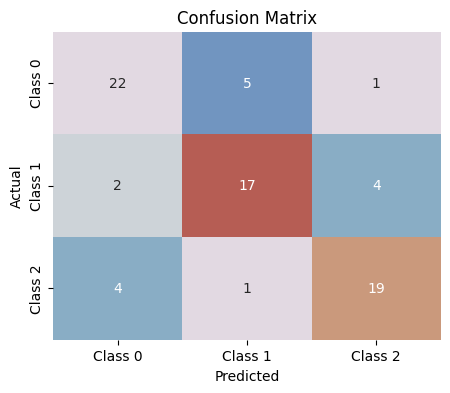

In [55]:
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='twilight', fmt='g', cbar=False, 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In the first row, 22 instances belonging to class 0 were correctly classified as such, while 5 instances were erroneously classified as class 1 and 1 instance as class 2. Similarly, the second row illustrates that 17 instances of class 1 were accurately identified, yet 2 instances were misclassified as class 0 and 4 instances as class 2. In the third row, 19 instances of class 2 were correctly predicted, with 4 instances misclassified as class 0 and 1 instance as class 1. This systematic examination of misclassifications provides valuable insights into the model's performance, highlighting areas of proficiency and deficiency across different classes. 

In summary, while the overall accuracy decreased in Question 4, the model's performance became more balanced across all classes, as evidenced by the more comparable precision, recall, and F1-score values. This suggests that the model in Question 4 might be considered more robust and reliable for multi-class classification tasks compared to the model in Question 3, which exhibited significant disparities in performance between classes.